In [2]:
#import some stuff
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import random
import math
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def clean_memory():
    gc.collect()           # Garbage collect Python objects
    torch.cuda.empty_cache()  # Clear cached memory on GPU


data_dir = "C:/Users/yueze/Desktop/GPT_two_qubit_polarization_tracking/20240506_2131.csv"
df = pd.read_csv(data_dir)
print(df.head)

features = ["AI0","AI1","AI2"]
targets  = ["AI3","AI4","AI5"]
x = df[features]  # Dropping original targets as we'll use aligned targets
y = df[targets]  # Using aligned targets
split_idx = int(len(df) * 0.9)
length_read=len(df)
# Split into training and testing sets
x_train = x.iloc[:split_idx]
y_train = y.iloc[:split_idx]
x_test = x.iloc[split_idx:]
y_test = y.iloc[split_idx:]

input_feature_dim = 3  # Each input element is a 1x3 vector
embed_size = 64
target_dim = 3
block_size = 40
num_heads = 16
max_iters = 144
batch_size = 10
eval_iters = 200
eval_interval = 1
num_layers=5

def get_batch3(split):
    # Select the correct data split
    if split == 'train':
        a, b, max_index = x_train, y_train, int(length_read * 0.9) - block_size - 1
    else:  # split == 'test'
        a, b, max_index = x_test, y_test, length_read - (int(length_read * 0.9) + block_size + 1)

    # Generate random indices for batch selection, ensuring they're within bounds
    ix = torch.randint(0, max_index, (batch_size,))

    # Initialize lists to hold the batches
    x_batch = []
    y_batch = []

    for i in ix:
        try:
                        # Extract the sequence from 'a' and the corresponding target from 'b'
            seq = torch.tensor(a.iloc[i.item():i.item() + block_size].astype(np.float32).values, dtype=torch.float32)
            target = torch.tensor(b.iloc[i.item() + block_size].astype(np.float32).values, dtype=torch.float32)

            x_batch.append(seq)
            y_batch.append(target)
        except IndexError as e:
            print(f"IndexError for index {i.item()}: {str(e)}")
            print(f"Attempting to access index [{i.item()}:{i.item() + block_size}] in 'a' with shape {a.shape}")
            print(f"Attempting to access index {i.item() + block_size} in 'b' with shape {b.shape}")
            # Optionally, break or continue depending on desired behavior on error
            break  # or continue

    if not x_batch or not y_batch:
        print("Error: Batch could not be created due to index issues.")
        return None, None

    # Stack the collected sequences and targets into tensors
    xstack = torch.stack(x_batch)
    ystack = torch.stack(y_batch)

    return xstack, ystack
class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size

        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.values = nn.Linear(embed_size, embed_size, bias=False)

    def forward(self, x):
        K = self.keys(x)
        Q = self.queries(x)
        V = self.values(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.embed_size ** 0.5
        attention = torch.softmax(attention_scores, dim=-1)

        attended = torch.matmul(attention, V)
        return attended

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads

        assert embed_size % num_heads == 0

        self.head_dim = embed_size // num_heads

        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.values = nn.Linear(embed_size, embed_size, bias=False)

        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, x):
        batch_size, seq_length, _ = x.shape

        keys = self.keys(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        queries = self.queries(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        values = self.values(x).view(batch_size, seq_length, self.num_heads, self.head_dim)

        attention_scores = torch.einsum("bnqh,bnkh->bnqk", [queries, keys]) / (self.head_dim ** 0.5)
        attention = torch.softmax(attention_scores, dim=-1)

        attended = torch.einsum("bnqk,bnkv->bnqv", [attention, values]).reshape(batch_size, seq_length, self.embed_size)

        output = self.fc_out(attended)
        return output

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch3(split)
            X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train
    del X, Y
    return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.dropout1 = nn.Dropout(0.1)

        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, 2 * embed_size),
            nn.ReLU(),
            nn.Linear(2 * embed_size, embed_size),
        )
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, value):
        x = self.norm1(value)
        attention_output = self.attention(x)
        x = value + self.dropout1(attention_output)  # Residual connection and dropout after attention
        x = self.norm2(x)
        feed_forward_output = self.feed_forward(x)
        out = value + self.dropout2(feed_forward_output)  # Residual connection and dropout after FFN
        return out

# Positional Encoding in Encoder class should be moved to the device
class Encoder(nn.Module):
    def __init__(self, input_feature_dim, embed_size, num_heads, num_layers, seq_length):
        super(Encoder, self).__init__()
        self.input_fc = nn.Linear(input_feature_dim, embed_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, embed_size)).to(device)
        self.layers = nn.ModuleList([
            TransformerBlock(embed_size, num_heads) for _ in range(num_layers)])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_fc(x)) + self.positional_encoding
        for layer in self.layers:
            x = layer(x)
        return x

    def to_cpu(self):
        # Move the entire model to CPU
        self.input_fc.to('cpu')
        self.positional_encoding.data = self.positional_encoding.data.cpu()
        for layer in self.layers:
            layer.to('cpu')
        self.relu.to('cpu')
        torch.cuda.empty_cache()

class EncoderDecoderModelWithMultiHeadAttention(nn.Module):
    def __init__(self, input_feature_dim, embed_size, target_dim, seq_length, num_heads, num_layers):
        super(EncoderDecoderModelWithMultiHeadAttention, self).__init__()
        self.encoder = Encoder(input_feature_dim, embed_size, num_heads, num_layers, seq_length)
        self.decoder = nn.Sequential(
            nn.Linear(embed_size, target_dim),
        )

    def forward(self, x, targets):
        encoded = self.encoder(x)
        encoded_pooled = torch.mean(encoded, dim=1)
        decoded = self.decoder(encoded_pooled)

        if targets is not None:
            loss = criterion(decoded, targets)
            return decoded, loss


        return decoded, None

    def to_cpu(self):
        self.encoder.to_cpu()
        for layer in self.decoder:
            layer.to('cpu')
        torch.cuda.empty_cache()



actuals = []
predictions = []
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = EncoderDecoderModelWithMultiHeadAttention(input_feature_dim, embed_size, target_dim, block_size, num_heads, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for iter in range(max_iters):
        # Evaluate the loss periodically
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        xb, yb = get_batch3('train')
        xb, yb = xb.to(device), yb.to(device)  # Ensure these tensors are on the correct device

        predictions, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
                # After using tensors in a training step
        del xb, yb, predictions  # Assuming these are not needed after the training step
        clean_memory()  # Call this to clear memory
    print("Loss:", loss.item())
    del loss  # Assuming these are not needed after the training step
    clean_memory()  # Call this to clear memoryq
    model.to_cpu()

<bound method NDFrame.head of           TimeStamps       AI0       AI1       AI2       AI3       AI4  \
0           0.000000  2.229548  0.295483 -1.081807  1.623932 -1.120879   
1           0.101122  2.219780  0.295483 -1.101343  1.633699 -1.101343   
2           0.203640  2.210012  0.285714 -1.081807  1.643468 -1.081807   
3           0.300221  2.219780  0.305250 -1.101343  1.653235 -1.072039   
4           0.403315  2.200244  0.315019 -1.101343  1.653235 -1.062271   
...              ...       ...       ...       ...       ...       ...   
711710  71171.002492 -0.964591 -2.029304 -1.062271 -0.925519  0.686203   
711711  71171.100106 -0.876678 -2.078144 -1.013431 -0.915751  0.676435   
711712  71171.201757 -0.759462 -2.136752 -0.993895 -0.896214  0.637362   
711713  71171.303305 -0.769231 -2.126984 -1.032967 -0.827839  0.656898   
711714  71171.401576 -0.769231 -2.146520 -0.896214 -0.905983  0.520146   

             AI5  
0      -1.492064  
1      -1.501831  
2      -1.501831  
3    

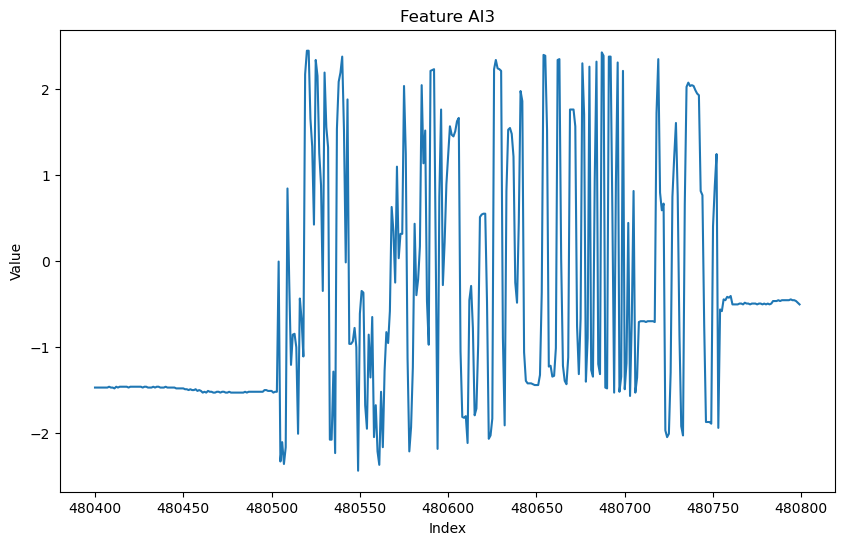

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df["AI3"][480400:480800])
plt.title('Feature AI3')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [4]:
#1.Find out what section of the data has human variations
#2.Train on those data
#3.Test the parameters around a bit to optimize the model
#4.Test the human variation data on the inherant data
#5.If result matches up, skip to step 9, else: fine tune parameter of original model, now with a weighted loss of the background data (the background data has too much significance as it stands and thus we need to reduce its weights in the model).
#6.Try the attention model on legacy dataset to see if the legacy dataset with more data improves performance
#7.We now deem that the models we have are insufficient. Hypothesis: current dataset lacks datapoint, legacy dataset lacks synchronization. Contact anirudth for better data.
#8.Throw the model that uses the current user-generated data to anirudth so he can see how well the data fits with new 2 day data.
#9.Write a report on the significance of the current best model, explaining what we're ultimately trying to accomplish, why its significant, and consice without too much technical detail (user manual) so that professors who have no background and no intuition about ML can realize the differences of this scheme

In [5]:
#step 1:
#10:70;450:675;466000:466150;480400:480800

In [6]:
#step2:
# Assuming df is your dataframe and it has the required columns
features = ["AI0", "AI1", "AI2"]
targets  = ["AI3", "AI4", "AI5"]

# Splicing indices
train_indices = list(range(10, 70)) + list(range(450, 675)) + list(range(466000, 466150)) + list(range(480400,480800))

# Create a mask for the training indices
mask = df.index.isin(train_indices)

# Select the rows for x_train and x_validation
x_train = df.iloc[mask][features]
y_train = df.iloc[mask][targets]

x_test = df.iloc[~mask][features]
y_test = df.iloc[~mask][targets]

# Output the lengths of the training and testing sets
print(f"Length of training set: {len(x_train)}")
print(f"Length of testing set: {len(x_test)}")
length_read=len(x_train)

Length of training set: 835
Length of testing set: 710880


In [7]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = EncoderDecoderModelWithMultiHeadAttention(input_feature_dim, embed_size, target_dim, block_size, num_heads, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for iter in range(max_iters):
        # Evaluate the loss periodically
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        xb, yb = get_batch3('train')
        xb, yb = xb.to(device), yb.to(device)  # Ensure these tensors are on the correct device

        predictions, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
                # After using tensors in a training step
        del xb, yb, predictions  # Assuming these are not needed after the training step
        clean_memory()  # Call this to clear memory
    print("Loss:", loss.item())
    del loss  # Assuming these are not needed after the training step
    clean_memory()  # Call this to clear memoryq
    model.to_cpu()

step 0: train loss 2.0782, val loss 2.0392
step 1: train loss 2.0888, val loss 1.3704
step 2: train loss 2.1264, val loss 0.7233
step 3: train loss 2.2464, val loss 0.4583
step 4: train loss 2.2257, val loss 0.3986
step 5: train loss 2.1494, val loss 0.3839
step 6: train loss 1.9970, val loss 0.4776
step 7: train loss 1.9076, val loss 0.5869
step 8: train loss 1.7403, val loss 0.5844
step 9: train loss 1.6676, val loss 0.5793
step 10: train loss 1.6412, val loss 0.5768
step 11: train loss 1.6412, val loss 0.6275
step 12: train loss 1.8392, val loss 0.6713
step 13: train loss 1.7749, val loss 0.6047
step 14: train loss 1.7900, val loss 0.4559
step 15: train loss 1.8010, val loss 0.3271
step 16: train loss 1.6860, val loss 0.2267
step 17: train loss 1.6001, val loss 0.1630
step 18: train loss 1.5871, val loss 0.1330
step 19: train loss 1.4962, val loss 0.1607
step 20: train loss 1.4960, val loss 0.2272
step 21: train loss 1.5875, val loss 0.3609
step 22: train loss 1.6915, val loss 0.524

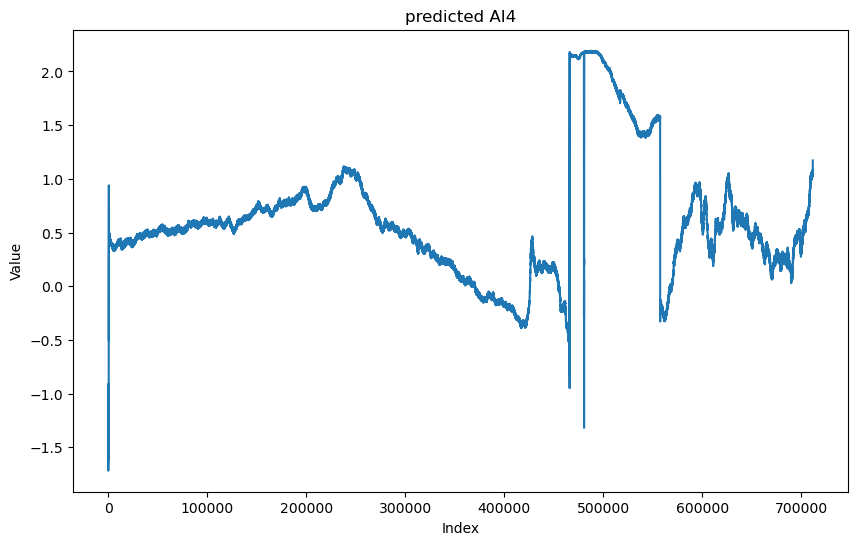

In [8]:
def prepare_full_dataset(x, block_size):
    full_sequences = []
    for i in range(len(x) - block_size):
        seq = torch.tensor(x.iloc[i:i + block_size].astype(np.float32).values)
        full_sequences.append(seq)

    full_dataset = torch.stack(full_sequences)
    return full_dataset

# Prepare the full dataset and send it to the correct device
x_full = prepare_full_dataset(df[features], block_size)
batch_size = 1000
num_samples = x_full.size(0)  # Get the total number of samples
all_predictions = []

model.to_cpu()  # Ensure the model is on the CPU

with torch.no_grad():
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)  # Calculate the end index of the batch
        batch_x = x_full[start_idx:end_idx]  # Extract the batch
        predictions_batch, _ = model(batch_x, None)  # Get predictions for the batch
        all_predictions.append(predictions_batch.cpu())  # Collect the predictions

# Concatenate all batch predictions into a single tensor
predictions_full = torch.cat(all_predictions, dim=0)
# Convert the first dimension of the predictions to a NumPy array for easier handling with matplotlib
AI3 = predictions_full[:, 0].numpy()
AI4 = predictions_full[:, 1].numpy()
AI5 = predictions_full[:, 2].numpy()

plt.figure(figsize=(10, 6))
plt.plot(AI4)
plt.title('predicted AI4')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [9]:
#now we have trained a model on tdf_full = pd.read_csv("./20240229_2308.csv", header=None)
df_full = pd.read_csv("./data_2.csv", header=None)

# The maximum length of the dataset is the number of rows
max_length = df_full.shape[0]

# Print the maximum length
print(f"The maximum length of the dataset is: {max_length}")

# Now, you can use this information to set length_read appropriately
length_read = min(12546000, max_length)  # for example, to limit it to 100000 or the maximum length available

df_reduced = df_full.iloc[::10000, :]
# Proceed with loading the desired portion of the dataset
df = pd.read_csv("./20240229_2308.csv", header=None).iloc[1:length_read, :6]
df.columns = ["l1","l2","l3","r1","r2","r3"]
df.head()
targets = ["r1", "r2", "r3"]
max_length = df.shape[0]

# Print the maximum length
print(f"The maximum length of the dataset is: {max_length}")
x = df.drop(columns=targets)
y = df[targets]

def prepare_full_dataset(x, block_size):
    full_sequences = []
    for i in range(len(x) - block_size):
        seq = torch.tensor(x.iloc[i:i + block_size].astype(np.float32).values)
        full_sequences.append(seq)
    full_dataset = torch.stack(full_sequences)
    return full_dataset

# Prepare the full dataset and send it to the correct device
x_full = prepare_full_dataset(x, block_size)

batch_size = 1000
num_samples = x_full.size(0)  # Get the total number of samples
all_predictions = []

model.to_cpu()  # Ensure the model is on the CPU

with torch.no_grad():
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)  # Calculate the end index of the batch
        batch_x = x_full[start_idx:end_idx]  # Extract the batch
        predictions_batch, _ = model(batch_x, None)  # Get predictions for the batch
        all_predictions.append(predictions_batch.cpu())  # Collect the predictions

# Concatenate all batch predictions into a single tensor
predictions_full = torch.cat(all_predictions, dim=0)

C:\Users\yueze\AppData\Local\Temp\ipykernel_11400\1830165733.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv("./data_2.csv", header=None)


The maximum length of the dataset is: 1736737


C:\Users\yueze\AppData\Local\Temp\ipykernel_11400\1830165733.py:15: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./20240229_2308.csv", header=None).iloc[1:length_read, :6]


The maximum length of the dataset is: 1736736


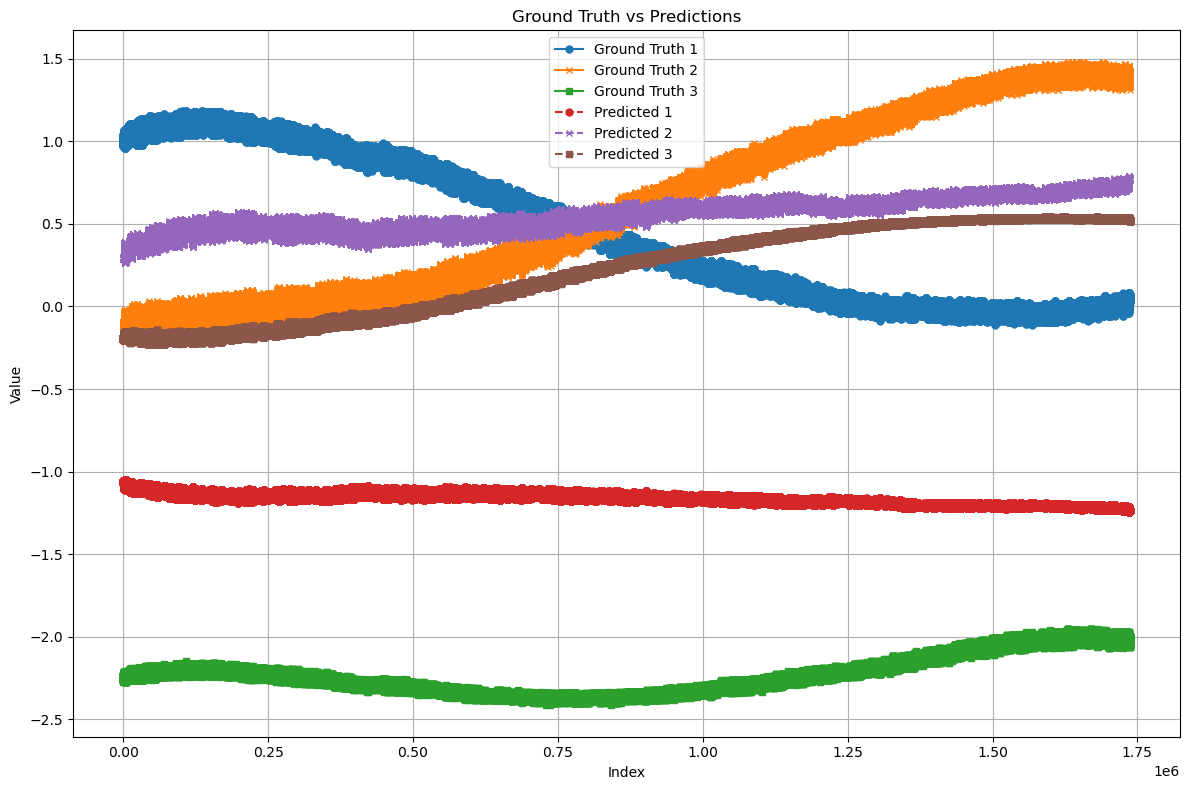

In [10]:
AI3 = predictions_full[:, 0].numpy()
AI4 = predictions_full[:, 1].numpy()
AI5 = predictions_full[:, 2].numpy()
plt.figure(figsize=(12, 8))
plt.plot(df['r1'].astype(np.float64).values, label="Ground Truth 1", marker='o', linestyle='-', markersize=5)
plt.plot(df['r2'].astype(np.float64).values, label="Ground Truth 2", marker='x', linestyle='-', markersize=5)
plt.plot(df['r3'].astype(np.float64).values, label="Ground Truth 3", marker='s', linestyle='-', markersize=5)
plt.plot(AI3, label="Predicted 1", marker='o', linestyle='--', markersize=5)
plt.plot(AI4, label="Predicted 2", marker='x', linestyle='--', markersize=5)
plt.plot(AI5, label="Predicted 3", marker='s', linestyle='--', markersize=5)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Ground Truth vs Predictions')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\yueze\AppData\Local\Temp\ipykernel_11400\4263749051.py:1: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv("./20240229_2308.csv", header=None)


The maximum length of the dataset is: 12546118


C:\Users\yueze\AppData\Local\Temp\ipykernel_11400\4263749051.py:14: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./20240229_2308.csv", header=None).iloc[1:length_read:10000, :6]


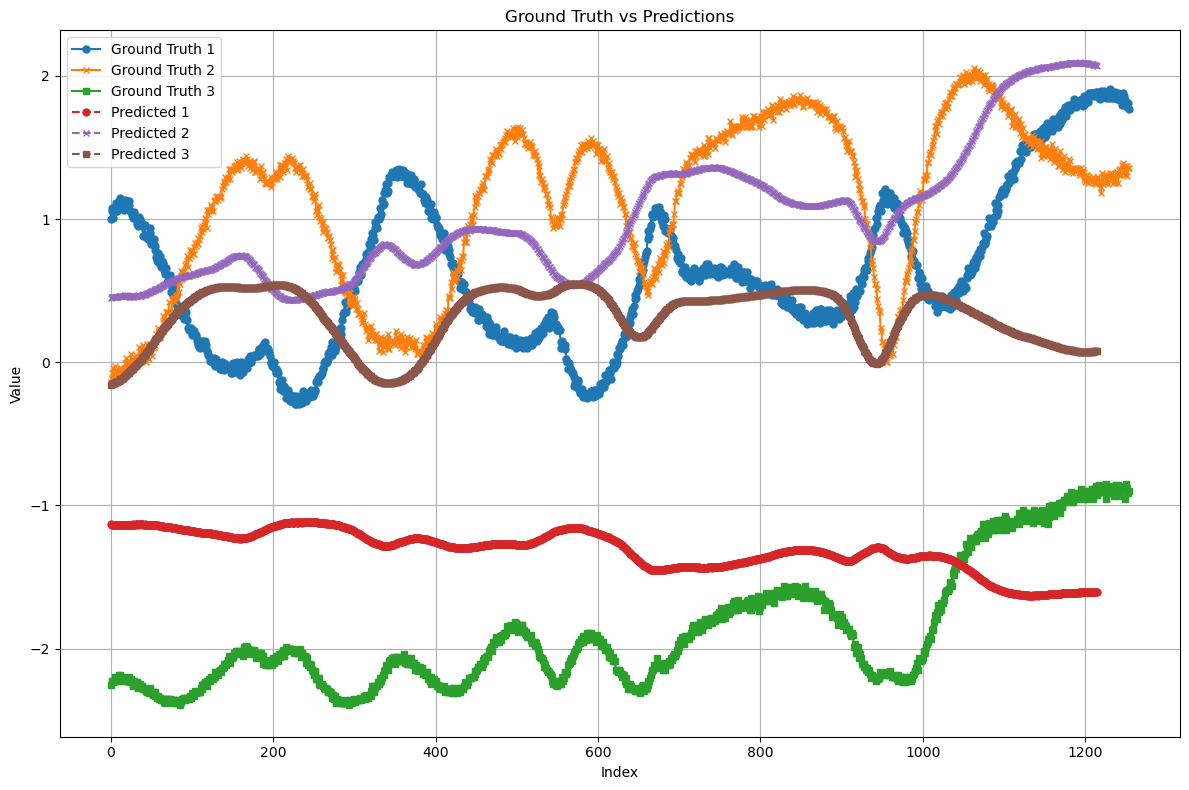

In [11]:
df_full = pd.read_csv("./20240229_2308.csv", header=None)

# The maximum length of the dataset is the number of rows
max_length = df_full.shape[0]

# Print the maximum length
print(f"The maximum length of the dataset is: {max_length}")

# Now, you can use this information to set length_read appropriately
length_read = min(12546000, max_length)  # for example, to limit it to 100000 or the maximum length available

df_reduced = df_full.iloc[::1000, :]
# Proceed with loading the desired portion of the dataset
df = pd.read_csv("./20240229_2308.csv", header=None).iloc[1:length_read:10000, :6]
df.columns = ["l1","l2","l3","r1","r2","r3"]
df.head()
targets = ["r1", "r2", "r3"]
x = df.drop(columns=targets)
y = df[targets]

x_full = prepare_full_dataset(x, block_size)

batch_size = 1000
num_samples = x_full.size(0)  # Get the total number of samples
all_predictions = []

model.to_cpu()  # Ensure the model is on the CPU

with torch.no_grad():
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)  # Calculate the end index of the batch
        batch_x = x_full[start_idx:end_idx]  # Extract the batch
        predictions_batch, _ = model(batch_x, None)  # Get predictions for the batch
        all_predictions.append(predictions_batch.cpu())  # Collect the predictions

# Concatenate all batch predictions into a single tensor
predictions_full = torch.cat(all_predictions, dim=0)

AI3 = predictions_full[:, 0].numpy()
AI4 = predictions_full[:, 1].numpy()
AI5 = predictions_full[:, 2].numpy()
plt.figure(figsize=(12, 8))
plt.plot(df['r1'].astype(np.float64).values, label="Ground Truth 1", marker='o', linestyle='-', markersize=5)
plt.plot(df['r2'].astype(np.float64).values, label="Ground Truth 2", marker='x', linestyle='-', markersize=5)
plt.plot(df['r3'].astype(np.float64).values, label="Ground Truth 3", marker='s', linestyle='-', markersize=5)
plt.plot(AI3, label="Predicted 1", marker='o', linestyle='--', markersize=5)
plt.plot(AI4, label="Predicted 2", marker='x', linestyle='--', markersize=5)
plt.plot(AI5, label="Predicted 3", marker='s', linestyle='--', markersize=5)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Ground Truth vs Predictions')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()